# **Introduction to SlangPy**

SlangPy is a python interface allowing you to launch shaders, kernels and device functions directly from python.
Its very easy to get going quickly, especially with compute.

First Steps

* Create a Slang device
* Load a Slang module
* Optionally query that module for any methods or datatypes
* Transfer data to the GPU from e.g. NumPy
* Execute functionality on the GPU using Slang.



## **Why SlangPy?**


* It's very easy to use
  * You can get shaders running in just 2 or 3 lines of Python code
  * Allows you to connect the GPU to a multitude of proven and understood Python libraries and methodologies


Let's get started.

Installing SlangPy is simple. The machines at SIGGRAPH have everything set up already but if you wanted to install SlangPy from scratch you would simply run:

`pip install slangpy`

Yes. It's that simple.

You can also build from source:

```bash
git clone https://github.com/shader-slang/slangpy.git --recursive`  
cd slangpy
pip install -r requirements-dev.txt
pip install .
```

When you have SlangPy installed, you can use it.

To use SlangPy, you need:

* One or more Slang modules
* A python file or notebook to work with the Slang module(s)


So lets look at it in action. In the last section we looked at Nia's wonderful Mandelbrot shader. Let's take that same shader, run it with SlangPy and display the results. This is the same shader, no modification.

In [ ]:
import slangpy as spy 
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import PIL.Image as img
from IPython.display import display


Firstly we create a SlangPy device, then load the Slang program, and create the kernel and pipeline.

We create a texture for the shader to write to, and a command encoder for the render command.

In [ ]:
fractal_size = 1024

device = spy.create_device(include_paths=[os.getcwd()])

tex = device.create_texture(
    width=fractal_size,
    height=fractal_size,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.shader_resource | spy.TextureUsage.unordered_access
)



Now we load the module 'Mandelbrot.slang' which has a `render` method, the `mandelbrot` method, a texture and 3 uniforms declared.

We access methods, including the main method from the module that we loaded in SlangPy.

We also get the opportunity to use the 'set' method to bind buffers, textures and uniforms by passing in a python dictionary specifying those elements.

We can then call the dispatch method that will call the shader's `render` method, specifying the launch bounds.

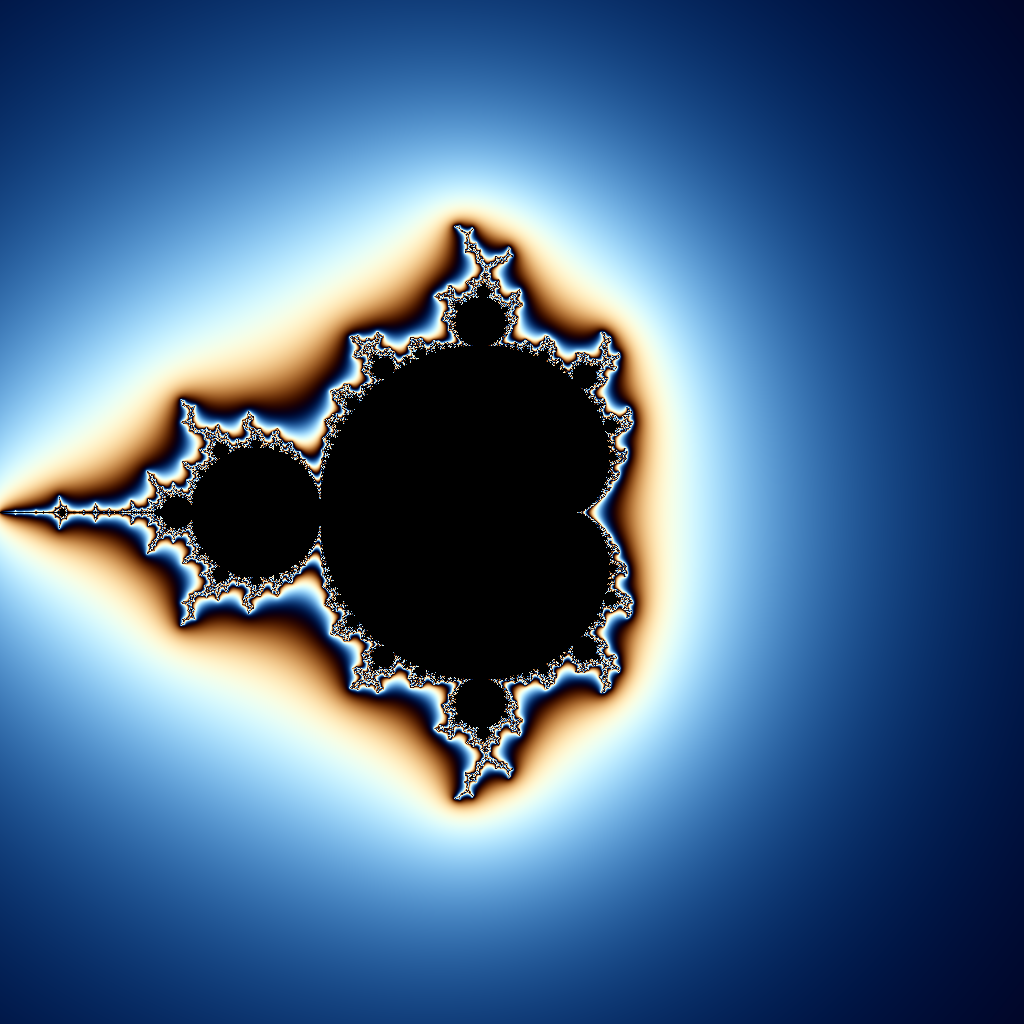

In [ ]:
module2 = spy.Module.load_from_file(device,"Mandelbrot.slang")
module2.render.set({
    'texFrame':tex,
    'iTime':0.0,
    'iResolution':spy.float2(tex.width,tex.height),
    'iMouse':spy.float4(0,0,0,0)
}).dispatch((tex.width,tex.height,1))

#tex_np = tex.to_numpy() * 255

tex_img = img.fromarray((tex.to_numpy() * 255).astype(np.uint8))

display(tex_img)

Let's unpack that a little bit further. 

In the background, SlangPy is leaning on a render hardware interface (RHI) to dispatch the work on the GPU, this is dependent on a number of factors including the plaform that we are running on, for example on a Mac it's likely to be using Metal as the backend, on Windows or linux with a GPU it's likely to be using Vulkan.

When you ask SlangPy to load a module, it will compile down to the appropriate intermediate repsresentation depending on the selected device type, e.g. SPIR-V, then dispatch that to the backend via the slangpy-rhi.

You can also specify the device type when you create the SlangPy devce to override the default. SlangPy has a number of backends available to it including Vulkan, D3D12, Metal, and CUDA.

![A diagram showing the above. A Slang shader is compiled for SPIR-V, Metal, or maybe other platforms. The shader is then run on the GPU, and then read back via Python/NumPy or displayed on the monitor.](slangpy.png)






We already looked at a simple example, now let's look at something even simpler. Here we are going to simply evaluate and plot a quadratic curve.

We will evalulate the curve using Slang, then pull the results back to the CPU as a NumPy array and plot them using matplotlib.

In the Mandelbrot example above, we specified our launch bounds, but we can also get SlangPy do to that for us. This abstracts away the details of using the GPU from us making SlangPy incredibly easy to use.


In [12]:

#create the Slang device
device = spy.create_device(include_paths=[os.getcwd()])

#load the module
module = spy.Module.load_from_file(device, "slangpy_intro.slang")


## Generate some input data using NumPy

When using SlangPy, it is common to use NumPy to work with CPU side data, then use this data on the GPU.

Let's generate some data. We will create variables to store

* Number of points we wish to plot
* The input data (x axis)
* Some coefficients to test our cubic polynomial

In [13]:

#point count
point_count = 128

#input data
min_val, max_val = -10,10
x_input = np.random.uniform(min_val,max_val,point_count).astype(np.float32)


#some test coefficients
a_input = 2
b_input = -5
c_input = 4

print(f"Using {point_count} points.")
print(f"x input : {x_input}")
print(f"Cubic coefficients : {a_input}, {b_input}, {c_input}")




Using 128 points.
x input : [ 5.9564238   3.1935055   7.778968    6.6721554  -7.0952373  -9.239856
 -2.795971    3.8654993   7.416781    6.619797   -4.639339   -7.7492867
  7.3104315  -2.774555   -8.15126    -1.8325839  -7.3446097   6.805934
 -1.6704684   7.56613     7.263245   -6.184786   -8.47163    -7.2856274
  4.750306   -7.65434     3.4466815   7.6718645  -3.133524    2.6761923
  7.3006544  -0.28486055 -5.1077347   1.614463   -2.1131623  -0.15754823
 -4.565291    5.756875    0.4999732   0.9915549   0.2117352  -8.063826
  4.2197165  -6.97712    -7.7663193  -4.862151    1.5957227  -3.710539
 -6.0534725   5.0129433   9.774048    6.726552    3.210997   -8.648983
 -6.9581094   2.4677715   7.36464     4.8819704   8.207189   -2.3051288
  1.4912192   0.4568275   3.8227375  -8.694652   -5.6682944   3.583682
  6.9048448  -5.097524   -8.20404     7.967353   -5.2053337  -7.2177258
  9.468293    9.970061   -6.6715765   7.1622024  -0.7657977  -1.781348
 -4.423684   -6.2722063  -6.4038324   2.59

## Call our cubic function from SlangPy

We are going to pass our **x_input** and our 3 **cubic coefficients** to the slang function defined in *slangpy_intro.slang"
... but wait ... isnt it expecting 4 floats and not a numpy array and 3 floats?

This is why Python and Slang work so well together. What's happening under the hood is that SlangPy is analyzing the inputs and working out how best to dispatch a kernel that maps the input data to threads on the GPU.  
What will be returned is going to be a SlangPy *Tensor* that contains an output value for each input that we provided.

In [15]:
y_output : spy.Tensor = module.quadratic(x=x_input, a=a_input, b=b_input, c=c_input, _result="tensor" )

## Plot the results

What we got back from slang is a SlangPy tensor which is on the GPU, what we want is CPU NumPy data, which is easy to get as you can actually pass a SlangPy tensor directly to any function that accepts a NumPy array, and it will know what to do.
 
You can also get an actual NumPy array back by calling:

```python
y_output.to_numpy()
```

We will use matplotlib to plot the results:

Text(0.5, 1.0, 'Cubic Plot')

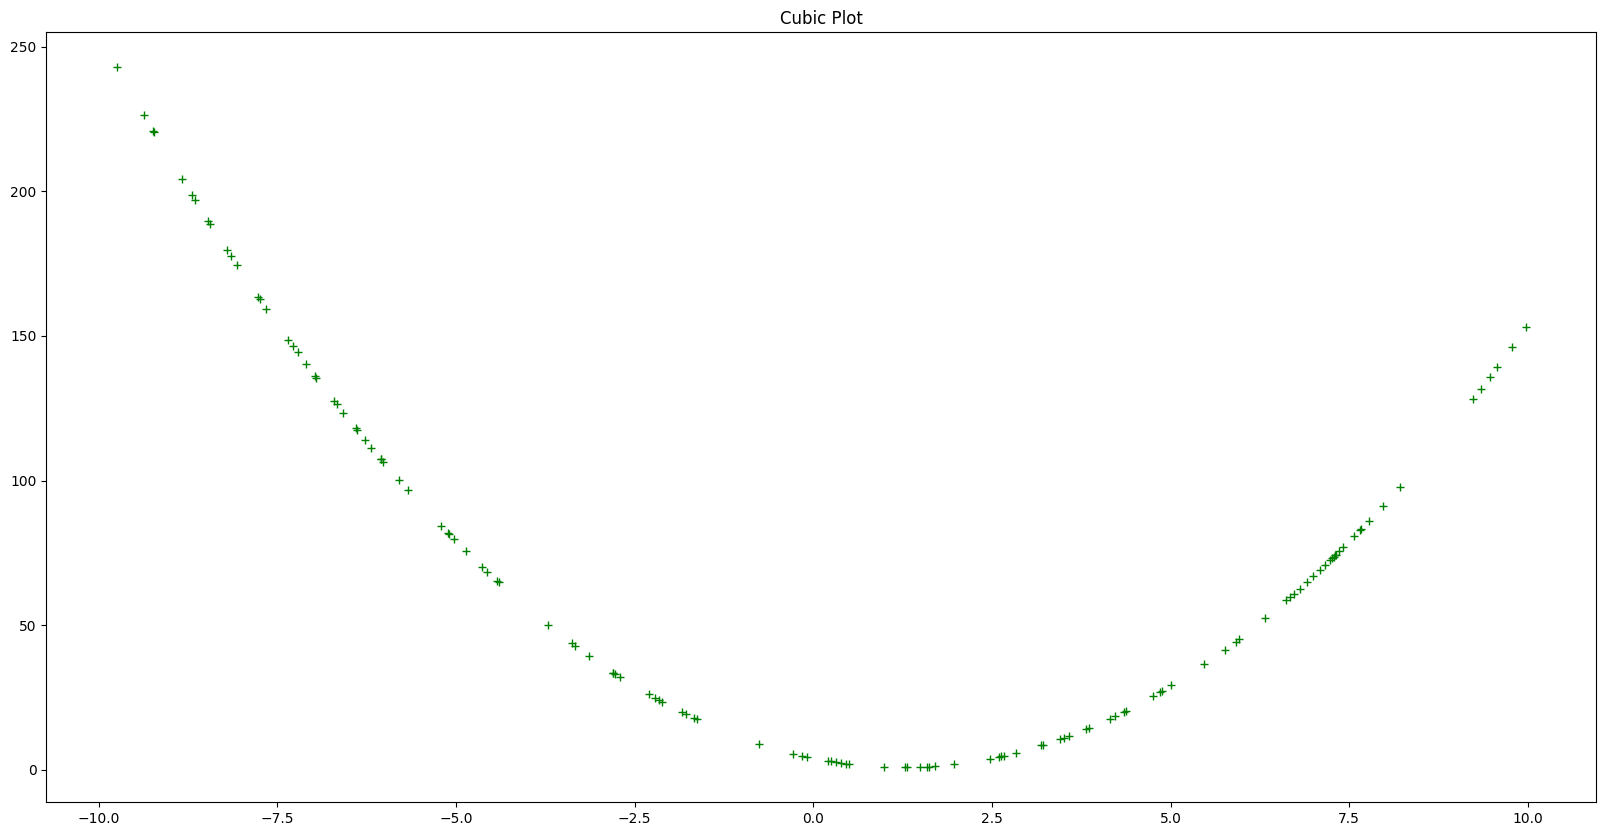

In [16]:
plt.figure(figsize=(20,10))
plt.plot(x_input,y_output,'g+')
plt.title("Cubic Plot")

## What if we wanted to pass our coefficients as a struct rather than as raw floating point values?

Of course we can do that.

Firstly we'll want to define our struct in our **slangpy_intro.slang** file.

```python
struct QuadraticCoeffs {
    float a; // coefficient for x²
    float b; // coefficient for x
    float c; // constant term
};
```

Now we'll write a new function that uses this struct as an input.

```python
float quadratic_v2(float x, QuadraticCoeffs coeffs) {
    return (coeffs.a * x * x) + (coeffs.b * x) + coeffs.c;
}
``` 


The module object that represents our Slang module contains references to the data types defined in it. We can access that type and map a Python dictionary to it.

In [17]:
quadratic_coeffs : module.QuadraticCoeffs = {
    'a':-1.0,
    'b':2.0,
    'c':3.0   
}

print(f"Coeffs : {quadratic_coeffs}")


Coeffs : {'a': -1.0, 'b': 2.0, 'c': 3.0}


Now we can pass that dictionary directly to the new version of our quadratic method.

Text(0.5, 1.0, 'Cubic Plot')

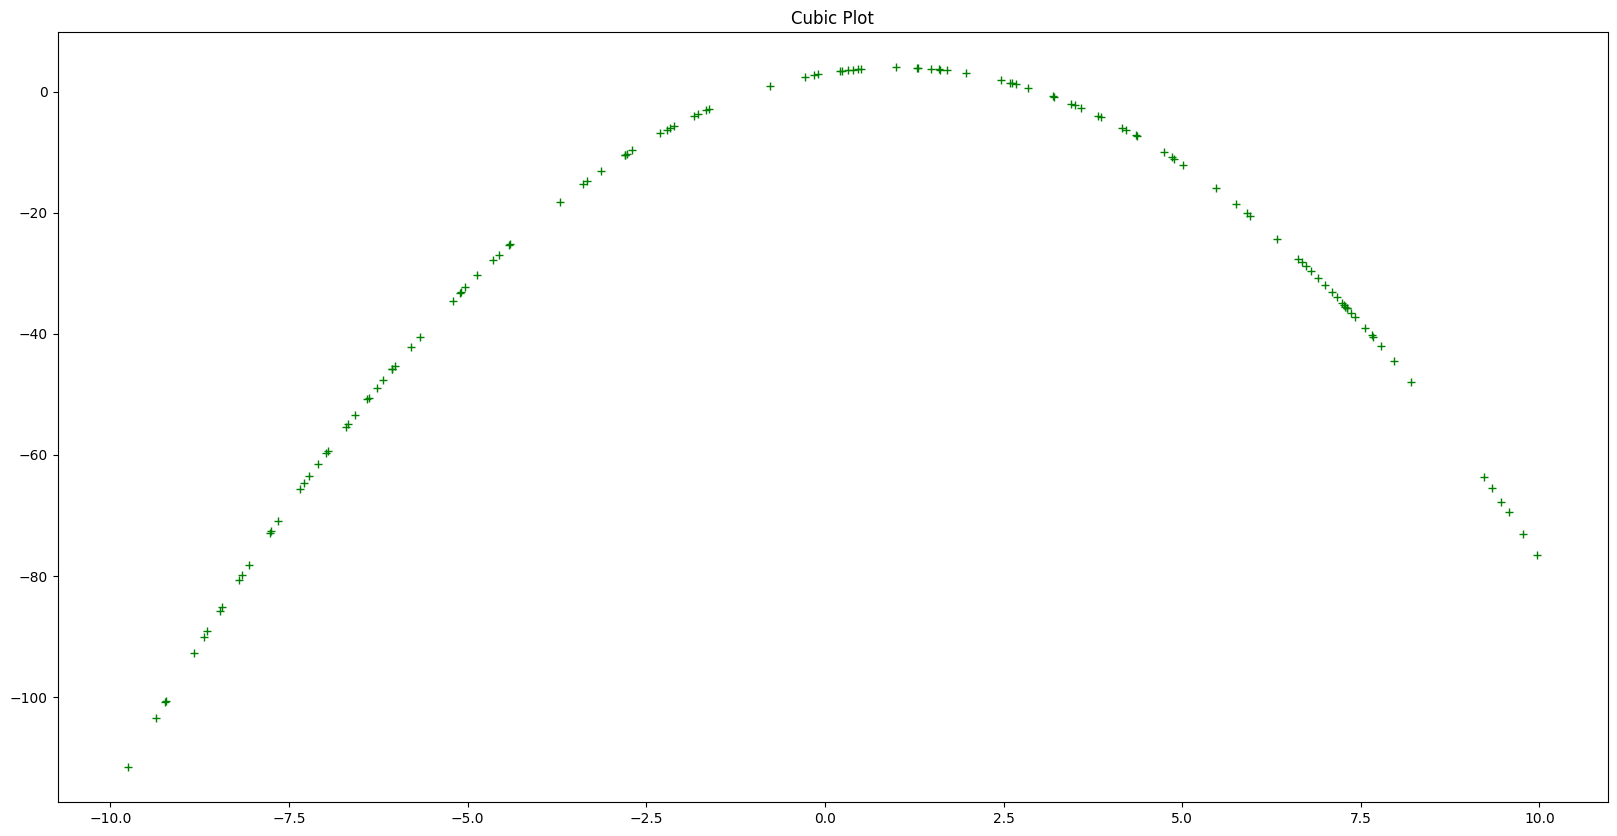

In [18]:

y_output_2 : spy.Tensor = module.quadratic_v2(x=x_input, coeffs=quadratic_coeffs, _result="tensor" )

plt.figure(figsize=(20,10))
plt.plot(x_input,y_output_2,'g+')
plt.title("Cubic Plot")

## What about buffers?

Can we create a buffer of types declared in Slang and pass that directly from Python?

Why yes .... yes we can, but it works slightly differently.

Let's do this for both the input and the output.

Let's define 2 new structs...

```python
struct QuadraticInput {
    float a; // coefficient for x²
    float b; // coefficient for x
    float c; // constant term
    float x;
}
  
struct QuadraticOutput {
    float y_a;
    float y_b;
    float y_c;
    float y;
}
```

Let's also create a new version of our quadratic function:

```python
void  quadratic_v3(QuadraticInput input, out QuadraticOutput output) {
    output.y_a = input.x * input.x * input.a;
    output.y_b = input.x * input.b;
    output.y_c = input.c;
    output.y = output.y_a + output.y_b + output.y_c;
}
```

Notice here we are not returning a value from the function, we marked our second argument as **out** as we are essentially asking for an array element back from this.
Here we individually compute the components of the quadratic, then sum them together in the **y** member of the output.


Now, back in SlangPy, we create 2 buffers, giving the device, the type that we query from the module, and the number of elements.

In [23]:
quadratic_input = spy.NDBuffer(device, dtype=module.QuadraticInput,shape=(point_count,))
quadratic_output = spy.NDBuffer(device, dtype=module.QuadraticOutput, shape=(point_count,))

Next we get a **cursor** (pointer) to that buffer's host side memory, then we can write a struct that matches the type of our type in Slang.  
Finally we 'apply' the cursor, which transfers the memory from the host side to the device side (cpu to gpu)

In [24]:

cursor_1 = quadratic_input.cursor()

for x in range(point_count):
    cursor_1[x].write(
        {
            'a': a_input,
            'b': b_input,
            'c': c_input,
            'x': x_input[x]         
        }
    )
    
cursor_1.apply()
    
print(quadratic_input)


Object(0x29128f2a288)


Now we can call the Slang method. This method does not return a value.

Let's quickly copy this data back to an array so we can plot it with NumPy also.

In [25]:


module.quadratic_v3(input=quadratic_input, output=quadratic_output )


cursor_2 = quadratic_output.cursor()

y_output_3 = []
for x in range(point_count):
    y_output_3.append(cursor_2[x].read()['y'])


print(y_output_3)


[45.17584991455078, 8.429428100585938, 86.12983703613281, 59.674537658691406, 140.1609649658203, 220.9491424560547, 33.61476135253906, 14.556673049926758, 76.93338012695312, 58.5444450378418, 70.2436294555664, 162.8493194580078, 74.33265686035156, 33.26908874511719, 177.64239501953125, 19.879648208618164, 148.60963439941406, 62.61180114746094, 17.933273315429688, 80.66200256347656, 73.1932373046875, 111.42707824707031, 189.8951873779297, 146.5888671875, 25.379287719726562, 159.44952392578125, 10.52581787109375, 83.3556900024414, 39.305564880371094, 4.943048477172852, 74.09584045410156, 5.586594104766846, 81.71658325195312, 1.1406660079956055, 23.496721267700195, 4.837384223937988, 68.51021575927734, 41.498844146728516, 2.0000803470611572, 1.0085877180099487, 3.030987501144409, 174.36968994140625, 18.513431549072266, 136.24600219726562, 163.46302795410156, 75.59178161621094, 1.1140484809875488, 50.088897705078125, 107.55642700195312, 29.19448471069336, 146.19378662109375, 60.86024475097

Again, let's plot the results.

Text(0.5, 1.0, 'Cubic Plot')

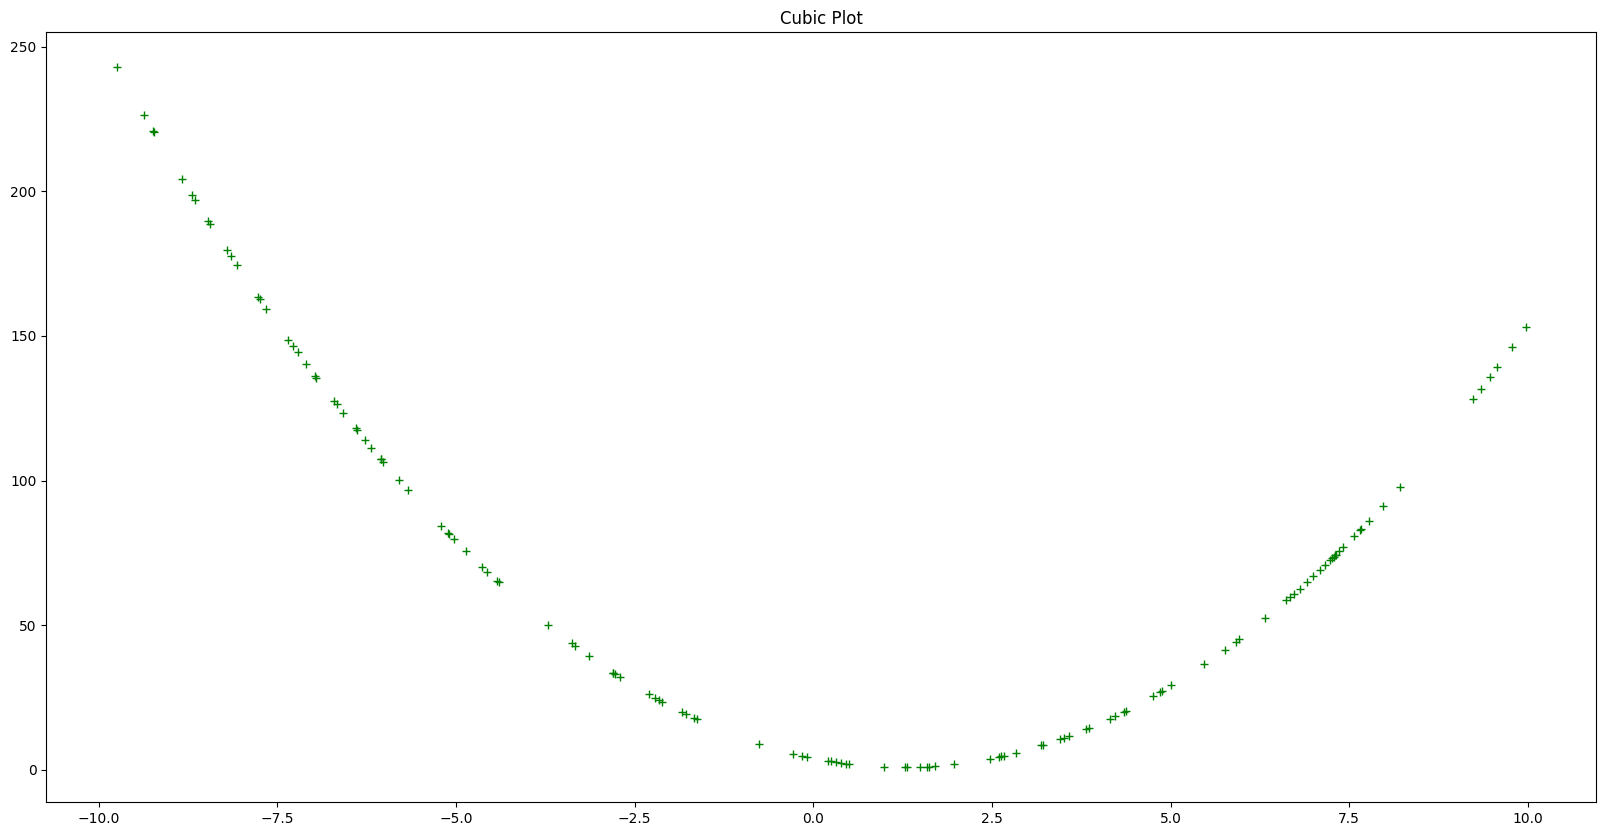

In [26]:

plt.figure(figsize=(20,10))
plt.plot(x_input,y_output_3,'g+')
plt.title("Cubic Plot")